## 降维算法实验

In [1]:
import numpy as np
import sys
import time

import os
import cv2
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.svm import SVC

In [2]:
from resnet import resnet
from preact_resnet import PreActResNet18
from datasets.load_cifar import load_cifar
from datasets.load_olivetti import load_olivetti

In [3]:
MODEL_DIR = './models/'

In [4]:
# 函数们
def rbg_to_grayscale(images):
    return np.dot(images[..., :3], [0.299, 0.587, 0.114])

def reshape_data(X_train, y_train, X_test):
    # reshape train and subtract mean
    pixel_mean = np.mean(X_train, axis=0)
    X_train -= pixel_mean
    X_test -= pixel_mean
    X_train_flip = X_train[:, :, :, ::-1]
    X_train = np.concatenate((X_train, X_train_flip), axis=0)
    y_train = np.concatenate((y_train, y_train), axis=0)
    return X_train, y_train, X_test

def image_metrics(img1, img2):
    # return mean abs error and cosine distance
    img1 = img1.astype(float).flatten()
    img2 = img2.astype(float).flatten()
    return np.mean(np.abs(img1 - img2)),  np.abs(np.dot(img1, img2) / (np.linalg.norm(img1) * np.linalg.norm(img2)))

def load_params(name):
    path = MODEL_DIR + name +".npz"
    with np.load(path) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    return param_values

def normalize(x):
    x_shape = x.shape
    x = x.flatten()
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min) / (x_max - x_min)
    return x.reshape(x_shape)

def iterate_minibatches(inputs, targets, batch_size):
    assert len(inputs) == len(targets)
    start_idx = None
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield inputs[excerpt], targets[excerpt]

    if start_idx is not None and start_idx + batch_size < len(inputs):
        excerpt = slice(start_idx + batch_size, len(inputs))
        yield inputs[excerpt], targets[excerpt]

#### 加载数据，构造恶意数据

In [5]:
def mal_data_synthesis(train_x, num_targets=10, precision=4):
    # synthesize malicious images to encode secrets
    # for CIFAR, use 2 data points to encode one approximate 4-bit pixel
    # thus divide the number of targets by 2
    num_targets //= 2
    if num_targets == 0:
        num_targets = 1

    targets = train_x[:num_targets]
    input_shape = train_x.shape
    if input_shape[1] == 3:  # rbg to gray scale
        targets = rbg_to_grayscale(targets.transpose(0, 2, 3, 1))

    mal_x = []
    mal_y = []
    for j in range(num_targets):
        target = targets[j].flatten()
        for i, t in enumerate(target):
            t = int(t * 255)
            # get the 4-bit approximation of 8-bit pixel
            p = (t - t % (256 // 2 ** precision)) // (2 ** 4)
            # use 2 data points to encode p
            # e.g. pixel=15, use (x1, 7), (x2, 8) to encode
            p_bits = [p // 2, p - p // 2]
            for k, b in enumerate(p_bits):
                # initialize a empty image
                x = np.zeros(input_shape[1:]).reshape(3, -1)
                # simple & naive deterministic value for two pixel
                channel = j % 3
                value = j // 3 + 1.0
                x[channel, i] = value
                if i < len(target) - 1:
                    x[channel, i + 1] = k + 1.0
                else:
                    x[channel, 0] = k + 1.0

                mal_x.append(x)
                mal_y.append(b)

    mal_x = np.asarray(mal_x, dtype=np.float32)
    mal_y = np.asarray(mal_y, dtype=np.int32)
    shape = [-1] + list(input_shape[1:])
    mal_x = mal_x.reshape(shape)
    return mal_x, mal_y, num_targets


In [7]:
# param_values = torch.load(MODEL_DIR+'cifar/resnet/cifar_cap_res5_0.1_model.ckpt')
param_values = torch.load(MODEL_DIR+'cifar/preact/cifar_cap_preact_resnet_0.1_model.ckpt')

X_train, y_train, X_test, y_test = load_cifar()

X_train = np.dstack((X_train[:, :1024], X_train[:, 1024:2048], X_train[:, 2048:]))
X_train = X_train.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:]))
X_test = X_test.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)

input_shape = (None, 3, X_train.shape[2], X_train.shape[3])
n_out = len(np.unique(y_train))

network = PreActResNet18(num_classes=10)
p = 0.1
mal_n = int(p * len(X_train) * 2)
network.load_state_dict(param_values)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [8]:
hidden_data_dim = np.prod(X_train.shape[2:])
mal_n //= hidden_data_dim

if mal_n == 0:
    mal_n = 1

# recreate malicious feature vector
X_mal, y_mal, mal_n = mal_data_synthesis(X_train, num_targets=mal_n)

X_train, y_train, X_test = reshape_data(X_train, y_train, X_test)
n_out = len(np.unique(y_train))

#### 隐藏层抽取

In [9]:
# 恶意数据隐藏层
out_list = []
network.to('cuda')
network.eval()
with torch.no_grad():
    for batch in iterate_minibatches(X_mal, y_mal, 128):
        inputs, _ = batch
        outs = network.inner(torch.from_numpy(inputs).to('cuda')).cpu().data.numpy()
        out_list.extend(list(outs))
np_out_list = np.array(out_list)
print(np_out_list.shape)

(8192, 512)


In [10]:
# 训练数据隐藏层
np_clean_list = []
with torch.no_grad():
    for batch in iterate_minibatches(X_train, y_train, 500):
        inputs, _ = batch
        outs = network.inner(torch.from_numpy(inputs).to('cuda')).cpu().data.numpy()
        np_clean_list.extend(list(outs))
np_clean_list = np.array(np_clean_list)
print(np_clean_list.shape)

(100000, 512)


In [11]:
# 测试数据隐藏层
np_test_list = []
with torch.no_grad():
    for batch in iterate_minibatches(X_test, y_test, 500):
        inputs, _ = batch
        outs = network.inner(torch.from_numpy(inputs).to('cuda')).cpu().data.numpy()
        np_test_list.extend(list(outs))
np_test_list = np.array(np_test_list)
print(np_test_list.shape)

(10000, 512)


#### 降维算法绘图

In [12]:
from sklearn.decomposition import PCA

from sklearn.manifold import MDS

from sklearn.manifold import TSNE

from sklearn.decomposition import KernelPCA

In [13]:
# 抽取参数的数量
train_nums = 200
test_nums = 1000

In [14]:
train = np_out_list[:train_nums]
mal_train = np_clean_list[:train_nums]
train_points = np.vstack([train, mal_train])

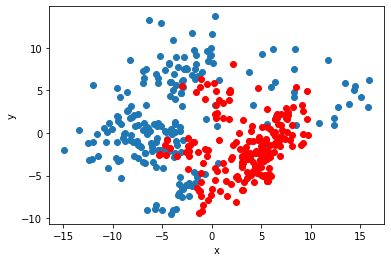

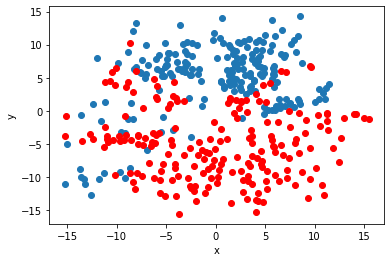

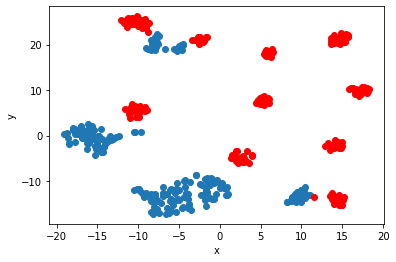

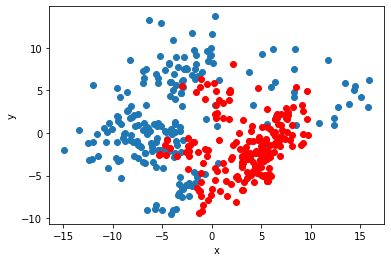

In [15]:
# 四种模型跑出图片来
for i, model in enumerate([PCA, MDS, TSNE, KernelPCA]):
    X = train_points
    X_embedded = model(n_components=2).fit_transform(X)
    x = X_embedded[:train_nums,0]
    y = X_embedded[:train_nums,1]
    plt.scatter(x, y)
    x = X_embedded[train_nums:,0]
    y = X_embedded[train_nums:,1]
    plt.scatter(x, y, c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    

In [16]:
# 四种模型训练集结果
for i, model in enumerate([PCA, MDS, TSNE, KernelPCA]):
    X = train_points
    X_embedded = model(n_components=2).fit_transform(X)
    Y_s = np.ones(train_nums, dtype=int)
    Y1_s = np.ones(train_nums,dtype=int)*2
    YY = np.append(Y_s, Y1_s)
    clf = SVC(gamma='auto')
    clf.fit(X_embedded, YY)
    tt = clf.predict(X_embedded)
    print(model.__name__)
    print("acc:",accuracy_score(tt, YY), end="\t")
    print("f1:",f1_score(tt, YY))

PCA
acc: 0.95	f1: 0.9504950495049505
MDS
acc: 0.9625	f1: 0.9622166246851385
TSNE
acc: 0.9975	f1: 0.9975062344139651
KernelPCA
acc: 0.95	f1: 0.9504950495049505


In [17]:
test = np_test_list[-test_nums:]
mal_test = np_out_list[-test_nums:]
test_points = np.vstack([test, mal_test])

In [18]:
# pca resnet cifar10 test
pca = PCA(n_components=2)
pca.fit(train_points)
YY_train = np.append(np.ones(train_nums, dtype=int), np.ones(train_nums,dtype=int)*2)
YY_test = np.append(np.ones(test_nums, dtype=int)*2, np.ones(test_nums,dtype=int))
from sklearn.svm import SVC
clf = SVC(gamma='auto')
# 用train来训练
X_embedded = pca.transform(train_points)
clf.fit(X_embedded, YY_train)

test_em = pca.transform(test_points)
tt = clf.predict(test_em)
print("acc:",accuracy_score(tt, YY_test), end="\t")
print("f1:",f1_score(tt, YY_test))
# plt.scatter(x, y, c=tt)

acc: 0.9155	f1: 0.9150326797385622


In [19]:
# kernelpca resnet cifar10 test
kpca = KernelPCA(n_components=2)
kpca.fit(train_points)
YY_train = np.append(np.ones(train_nums, dtype=int), np.ones(train_nums,dtype=int)*2)
YY_test = np.append(np.ones(test_nums, dtype=int)*2, np.ones(test_nums,dtype=int))
from sklearn.svm import SVC
clf = SVC(gamma='auto')
# 用train来训练
X_embedded = kpca.transform(train_points)
clf.fit(X_embedded, YY_train)

test_em = pca.transform(test_points)
tt = clf.predict(test_em)
print("acc:",accuracy_score(tt, YY_test), end="\t")
print("f1:",f1_score(tt, YY_test))
# plt.scatter(x, y, c=tt)

acc: 0.9155	f1: 0.9150326797385622


In [20]:
# direct resnet cifar10 test
YY_train = np.append(np.ones(train_nums, dtype=int), np.ones(train_nums,dtype=int)*2)
YY_test = np.append(np.ones(test_nums, dtype=int)*2, np.ones(test_nums,dtype=int))
from sklearn.svm import SVC
clf = SVC(gamma='auto')
# 用train来训练
clf.fit(train_points, YY_train)

tt = clf.predict(test_points)
# print(np.sum(np.equal(tt, YY_test)))
print("acc:",accuracy_score(tt, YY_test), end="\t")
print(f1_score(tt, YY_test))
# print("acc:",np.sum(np.equal(tt, YY_test))/test_nums/2)
# plt.scatter(x, y, c=tt)

acc: 0.9375	0.9334752527940394
